In [3]:
import os
import numpy
import re
from time import time
import pandas as pd
from pandas import DataFrame
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import TruncatedSVD

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [4]:
def remove_stops(obs):
    stops = set(stopwords.words('english'))
    tokens = obs.apply(lambda x: [item for item in x if item not in stops])
    print(str(type(tokens)))
    return tokens

def preprocess(df, remove_stopwords=True):
    obs = df.text.str.lower()
    obs = obs.str.replace(r'https?:\/\/.*[\r\n]*', '') # remove http(s) links
    obs = obs.str.replace(r'@[A-Za-z0-9]+', '') # remove mentions
    obs = obs.str.strip()
    obs = obs.str.strip('""')
    obs = obs.apply(nltk.word_tokenize)
    if (remove_stopwords):
        obs = remove_stops(obs)
    obs = obs.str.join(' ')
    tweets['text'] = obs
    return obs

In [5]:
tweets = pd.read_csv('tweets_by_user.csv')
preprocess(tweets, remove_stopwords=False)
tweets.head(5)

,userID,text
0,6,there is one on my train too .
1,9,rt : the `` life of the mother '' argument for...
2,11,broken toes and fracture ... .
3,27,its been a tough one no doubt ... its been a t...
4,51,rt : fact check : saying `` how stupid is our ...


In [6]:
users = pd.read_csv('users.csv')
df = pd.merge(tweets, users, on='userID')

df.head(5)
df = df.dropna()
df.shape

(1866, 4)

In [7]:
df.head(15)

,userID,text,state_code,party
5,52,i was pessimistic until right now but ketel wa...,AK,D
6,53,"study isaiah , the book jesus quoted most , wi...",AK,I
8,73,paid family leave is a critical economic issue...,AK,D
10,78,rt : so true and i do n't know either . at lea...,AK,I
12,113,# debatenight,AZ,I
16,156,"rt : hillary loves her father , a life long re...",AZ,R
19,180,i 'm obviously one of the political geeks watc...,AZ,R
20,193,"underwood 2016rt : holy shit , he just defende...",AZ,I
21,196,rt : trump is so out of touch he does n't even...,AZ,R
24,216,rt : is hillary calling for sensitivity traini...,AZ,I


In [8]:
from sklearn.pipeline import FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import classification_report

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lsa', TruncatedSVD()),
    ('clf', LinearSVC())
])
# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__stop_words': (None, 'english'),
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'lsa__n_components': (100, 250, 350)
    #'clf__n_iter': (10, 50, 80),
}

class DataFrameColumnExtracter(TransformerMixin):
    def __init__(self, column):
        self.column = column
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.column]
    def get_params(self):
        return None
    
class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""
    def fit(self, x, y=None):
        return self
    def transform(self, observations):
        return [{'state': str(state)}
                for state in observations]
    def get_params(self):
        return None

features = Pipeline([
        ('union', FeatureUnion([
                    ('dtm', Pipeline([
                                ('tfidf', TfidfVectorizer(stop_words=None)),
                                ('lsa', TruncatedSVD(n_components=100))
                            ])),
                    ('state', Pipeline([
                                ('colSelector', DataFrameColumnExtracter(column='state_code')),
                                ('state', TextStats())
                                ])
                     )
                ])),
        ('classifier', LinearSVC())
    ])


X_train, X_test, y_train, y_test = train_test_split(df['text'], df['party'], test_size=0.33)
print("Performing feature union...")
print("feature union:", [name for name, _ in features.steps])
print("classification report:")

pipeline.fit(X_train, y_train)
y_predictions = pipeline.predict(X_test)
print(classification_report(y_predictions, y_test))
y_test


Performing feature union...
feature union: ['union', 'classifier']
classification report:
             precision    recall  f1-score   support

          D       1.00      0.44      0.62       616
          G       0.00      0.00      0.00         0
          I       0.00      0.00      0.00         0
          L       0.00      0.00      0.00         0
          O       0.00      0.00      0.00         0
          R       0.00      0.00      0.00         0

avg / total       1.00      0.44      0.62       616



/Users/carrie/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


1193    D
2373    D
1490    D
1473    D
3089    D
2840    I
2932    R
2125    R
1022    D
1888    D
2653    R
1295    D
661     R
1017    D
2639    D
485     D
910     R
3075    D
718     R
779     D
3067    I
633     R
1423    R
1466    I
225     D
1774    R
517     D
2350    R
1386    D
514     I
       ..
1298    D
1334    D
1442    D
1117    D
1392    I
2514    D
182     D
2455    O
1698    D
2115    D
825     D
2213    D
2170    D
206     L
1163    D
1379    D
951     D
621     D
1616    O
2588    D
3034    D
1012    I
2466    I
1265    R
1170    D
2079    I
1537    R
1091    D
1172    D
1310    D
Name: party, dtype: object

In [6]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lsa', TruncatedSVD()),
    ('clf', RandomForestClassifier())
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__stop_words': (None, 'english'),
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'lsa__n_components': (100, 250, 350)
    #'clf__n_iter': (10, 50, 80),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-8, verbose=1)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['party'], test_size=0.33)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tfidf', 'lsa', 'clf']
parameters:
{'lsa__n_components': (100, 250, 350), 'tfidf__max_df': (0.5, 0.75, 1.0), 'tfidf__stop_words': (None, 'english'), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-8)]: Done 108 out of 108 | elapsed: 10.2min finished


done in 611.698s

Best score: 0.489
Best parameters set:
	lsa__n_components: 250
	tfidf__max_df: 0.5
	tfidf__ngram_range: (1, 1)
	tfidf__stop_words: None


# Drop Independents and test performance

In [9]:
df = df[df.party != 'I']
df = df[df.party != 'G']
df = df[df.party != 'L']
df = df[df.party != 'O']
df.head(5)

,userID,text,state_code,party
5,52,i was pessimistic until right now but ketel wa...,AK,D
8,73,paid family leave is a critical economic issue...,AK,D
16,156,"rt : hillary loves her father , a life long re...",AZ,R
19,180,i 'm obviously one of the political geeks watc...,AZ,R
21,196,rt : trump is so out of touch he does n't even...,AZ,R


In [10]:
df.shape

(1264, 4)

In [11]:
output_file = "DR_users.csv"
df.to_csv(output_file, header="'userID', 'text', 'state_code', 'party'")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120f00160>]], dtype=object)

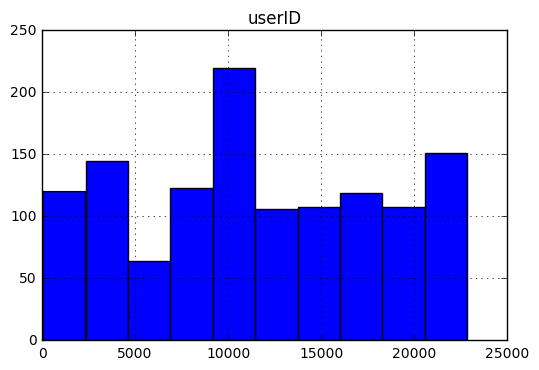

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline
df.hist()

In [144]:
from sklearn.pipeline import FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import classification_report

class DataFrameColumnExtracter(TransformerMixin):
    def __init__(self, column):
        self.column = column
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.column]
    def get_params(self):
        return None
    
class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""
    def fit(self, x, y=None):
        return self
    def transform(self, observations):
        return [{'state': str(state)}
                for state in observations]
    def get_params(self):
        return None

features = Pipeline([
        ('union', FeatureUnion([
                    ('dtm', Pipeline([
                                ('tfidf', TfidfVectorizer(stop_words=None)),
                                ('lsa', TruncatedSVD(n_components=100))
                            ])),
                    ('state', Pipeline([
                                ('colSelector', DataFrameColumnExtracter(column='state_code')),
                                ('state', TextStats())
                                ])
                     )
                ])),
        ('classifier', LinearSVC())
    ])


X_train, X_test, y_train, y_test = train_test_split(df['text'], df['party'], test_size=0.33)
print("Performing feature union...")
print("feature union:", [name for name, _ in features.steps])
print("classification report:")

pipeline.fit(X_train, y_train)
y_predictions = pipeline.predict(X_test)
print(classification_report(y_predictions, y_test))

y_test

Performing feature union...
feature union: ['union', 'classifier']
classification report:
             precision    recall  f1-score   support

          D       1.00      0.70      0.83       418
          R       0.00      0.00      0.00         0

avg / total       1.00      0.70      0.83       418



/Users/carrie/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


3044    D
2354    R
2478    D
927     D
1180    D
596     D
2070    R
1637    D
3115    R
1590    R
2235    R
3023    R
238     D
2381    D
1995    R
1192    D
2110    D
53      D
661     R
2972    D
619     R
79      D
551     D
1797    R
2951    R
1456    D
1411    D
2319    R
906     D
1539    R
       ..
114     R
446     D
1091    D
479     R
2767    D
1758    R
1727    R
779     D
173     D
63      D
617     R
1088    D
2264    D
1905    R
2040    R
1328    R
553     D
326     R
1449    D
1147    D
888     D
853     D
995     D
1343    D
3055    D
1799    R
225     D
26      D
420     D
763     R
Name: party, dtype: object

In [105]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lsa', TruncatedSVD()),
    ('clf', RandomForestClassifier())
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    #'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__stop_words': (None, 'english'),
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'lsa__n_components': (25, 50, 100)
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-8, verbose=1)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['party'], test_size=0.33)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
t0 = time()
grid_search.fit(df['text'], df['party'])
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tfidf', 'lsa', 'clf']
parameters:
{'lsa__n_components': (25, 50, 100), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-8)]: Done  18 out of  18 | elapsed:   16.2s finished


done in 16.691s

Best score: 0.663
Best parameters set:
	lsa__n_components: 100
	tfidf__ngram_range: (1, 1)


In [106]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lsa', TruncatedSVD()),
    ('clf', LinearSVC())
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    #'tfidf__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__stop_words': (None, 'english'),
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'lsa__n_components': (100, 250, 350)
    #'clf__n_iter': (10, 50, 80),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-8, verbose=1)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['party'], test_size=0.33)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tfidf', 'lsa', 'clf']
parameters:
{'lsa__n_components': (100, 250, 350), 'tfidf__ngram_range': ((1, 1), (1, 2))}
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-8)]: Done  18 out of  18 | elapsed:   27.0s finished


done in 27.247s

Best score: 0.665
Best parameters set:
	lsa__n_components: 100
	tfidf__ngram_range: (1, 1)


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV

class EstimatorSearch:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            z = dict(list(params.items()) + list(d.items()))
            return pd.Series(z)

        rows = [row(k, gsc.cv_validation_scores, gsc.parameters)
                     for k in self.keys
                     for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

from sklearn import datasets

iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier,
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC

models = {
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC()
}

params = {
    'ExtraTreesClassifier': { 'n_estimators': [16, 32] },
    'RandomForestClassifier': { 'n_estimators': [16, 32] },
    'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
    'SVC': [
        {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    ]
}

search = EstimatorSearch(models, params)
search.fit(X_iris, y_iris, scoring=None, n_jobs=-1)

print(search.score_summary())
#print(summary.head())


Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished


Running GridSearchCV for ExtraTreesClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished


Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for SVC.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished


                     estimator min_score mean_score max_score  std_score    C  \
10                         SVC  0.960784   0.979984         1  0.0160202    1   
11                         SVC  0.921569   0.973856         1  0.0369729   10   
4   GradientBoostingClassifier  0.921569    0.96732         1  0.0333269  NaN   
5   GradientBoostingClassifier  0.921569    0.96732         1  0.0333269  NaN   
8       RandomForestClassifier  0.921569    0.96732         1  0.0333269  NaN   
9       RandomForestClassifier  0.921569    0.96732         1  0.0333269  NaN   
7         ExtraTreesClassifier  0.901961   0.960784         1  0.0423578  NaN   
2   GradientBoostingClassifier  0.921569   0.960376  0.980392  0.0274454  NaN   
3   GradientBoostingClassifier  0.921569   0.960376  0.980392  0.0274454  NaN   
0           AdaBoostClassifier  0.941176   0.959967  0.980392  0.0160514  NaN   
1           AdaBoostClassifier  0.941176   0.959967  0.980392  0.0160514  NaN   
6         ExtraTreesClassifi

/Users/carrie/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/carrie/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/carrie/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/carrie/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:66

In [107]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

class EstimatorSearch:
    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            z = dict(list(params.items()) + list(d.items()))
            return pd.Series(z)

        rows = [row(k, gsc.cv_validation_scores, gsc.parameters)
                     for k in self.keys
                     for gsc in self.grid_searches[k].grid_scores_]
        df = pd.concat(rows, axis=1).T.sort([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

X = df['text']
y = df['party']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
tfidf = TfidfVectorizer(stop_words='english', max_df=1)
svd = TruncatedSVD(n_components=100)
normalizer = Normalizer(copy=False)

pipeline = make_pipeline(tfidf, svd, normalizer)

X_train_dtm = pipeline.fit_transform(X)


from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier,
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC

models = {
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(),
    'SVC': SVC()
}

params = {
    'ExtraTreesClassifier': { 'n_estimators': [16, 32] },
    'RandomForestClassifier': { 'n_estimators': [16, 32] },
    'AdaBoostClassifier':  { 'n_estimators': [16, 32] },
    'GradientBoostingClassifier': { 'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0] },
    'SVC': [
        {'kernel': ['linear'], 'C': [1, 10]},
        {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.001, 0.0001]},
    ]
}

search = EstimatorSearch(models, params)
search.fit(X_train_dtm, y, scoring=None, n_jobs=-1)

print(search.score_summary())

Running GridSearchCV for AdaBoostClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for GradientBoostingClassifier.
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    1.9s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.0s finished


Running GridSearchCV for ExtraTreesClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Running GridSearchCV for RandomForestClassifier.
Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


Running GridSearchCV for SVC.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.3s finished


                     estimator min_score mean_score max_score   std_score  \
10                         SVC  0.665158   0.665914  0.667426  0.00106896   
12                         SVC  0.665158   0.665914  0.667426  0.00106896   
13                         SVC  0.665158   0.665914  0.667426  0.00106896   
14                         SVC  0.665158   0.665914  0.667426  0.00106896   
15                         SVC  0.665158   0.665914  0.667426  0.00106896   
7         ExtraTreesClassifier  0.656109   0.659871   0.66287  0.00281259   
9       RandomForestClassifier  0.649203   0.654561  0.662896  0.00597345   
8       RandomForestClassifier  0.635535   0.648497  0.667421    0.013683   
6         ExtraTreesClassifier  0.638009   0.643249  0.649203  0.00459766   
11                         SVC  0.585421   0.605397  0.626697   0.0168766   
3   GradientBoostingClassifier  0.585421   0.600872  0.622172    0.015563   
5   GradientBoostingClassifier  0.583144   0.597096  0.617647   0.0148386   

[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.7s finished
/Users/carrie/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/carrie/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/carrie/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
/Users/carrie/ana